Using the PyTorch NGC Container requires the host system to have the following installed:

    Docker Engine
    NVIDIA GPU Drivers
    NVIDIA Container Toolkit


https://docs.nvidia.com/deeplearning/frameworks/preparing-containers/index.html


https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch

https://docs.nvidia.com/deeplearning/frameworks/pytorch-release-notes/rel-24-06.html

https://docs.nvidia.com/deeplearning/modulus/getting-started/index.html


https://docs.nvidia.com/deeplearning/modulus/modulus-core/tutorials/simple_training_example.html

built-in models:
https://docs.nvidia.com/deeplearning/modulus/modulus-core/api/modulus.models.html#module-modulus.models

https://docs.nvidia.com/deeplearning/modulus/modulus-core/api/modulus.models.html#modulus-models-from-torch



## Dia 10 de Agosto eles atualizaram a instalação do Módulus e agora pode ser feito diretamente com o pip sem precisar do Container Toolkit e CUDA manualmente instalados, aumentou a qualidade de vida em 1000%
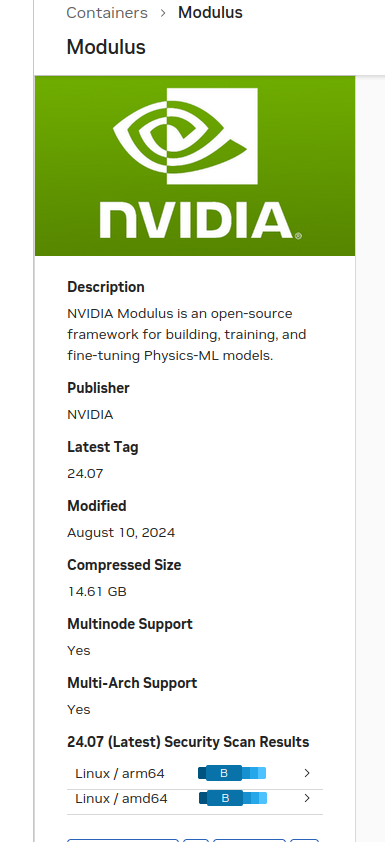

In [ ]:
!pip install https://github.com/NVIDIA/warp/releases/download/v1.3.1/warp_lang-1.3.1+cu11-py3-none-manylinux2014_x86_64.whl
!pip install nvidia-modulus nvidia-modulus-sym
!pip install warp-lang wandb mlflow pytorch

In [ ]:
import torch
import modulus
#Automaticamente sobrescreve as classes do PyTorch quando importado depois

In [ ]:
normaliser = {
    "permeability": (1.25, 0.75),
    "darcy": (4.52e-2, 2.79e-2),
}
dataloader = Darcy2D(
    resolution=256, batch_size=64, nr_permeability_freq=5, normaliser=normaliser
)
model = FNO(
    in_channels=1,
    out_channels=1,
    decoder_layers=1,
    decoder_layer_size=32,
    dimension=2,
    latent_channels=32,
    num_fno_layers=4,
    num_fno_modes=12,
    padding=5,
).to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda step: 0.85**step
)

# run for 20 iterations
for i in range(20):
    batch = next(iter(dataloader))
    true = batch["darcy"]
    pred = model(batch["permeability"])
    loss = mse(pred, true)
    loss.backward()
    optimizer.step()
    scheduler.step()

    print(f"Iteration:{i}. Loss:{loss.detach().cpu().numpy()}")

### O Modulus soobreescreve a classe Module em torch.nn , gerando alteração mínima no código, e logo está pronto para ser parametrizado a fim de utilizar todos os benefícios do Module.

In [ ]:
#model building -> pytorch standard

import torch.nn as nn

import modulus
from modulus.datapipes.benchmarks.darcy import Darcy2D
from modulus.metrics.general.mse import mse

##Pytorch
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)

        self.dec1 = self.upconv_block(128, 64)
        self.dec2 = self.upconv_block(64, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.dec1(x)
        x = self.dec2(x)
        return self.final(x)

In [ ]:

from dataclasses import dataclass

import torch.nn as nn

from modulus.models.meta import ModelMetaData
from modulus.models.module import Module


@dataclass
class MdlsUNetMetaData(ModelMetaData):
    name: str = "MdlsUNet"
    # Optimization
    jit: bool = False
    cuda_graphs: bool = True
    amp_cpu: bool = True
    amp_gpu: bool = True


MdlsUNet = Module.from_torch(UNet, meta=MdlsUNetMetaData)

## A Biblioteca Modulus Sym tem modelos e otimizadores próprios para simulações.

In [ ]:
#using ModulusSym repository
# Arch class from Modulus Sym that provides
# - utilites and methods to go from a tensor data to a dict format which Modulus Sym uses.
from typing import Dict, Optional

from modulus.sym.key import Key
from modulus.sym.models.arch import Arch


class MdlsSymUNet(Arch):
    def __init__(
        self,
        input_keys=[Key("a")],
        output_keys=[Key("b")],
        in_channels=1,
        out_channels=1,
    ):
        super(MdlsSymUNet, self).__init__(
            input_keys=input_keys, output_keys=output_keys
        )

        self.mdls_model = MdlsUNet(in_channels, out_channels)  # MdlsUNet defined above

    def forward(self, dict_tensor: Dict[str, torch.Tensor]):
        x = self.concat_input(
            dict_tensor,
            self.input_key_dict,
            detach_dict=None,
            dim=1,
        )
        out = self.mdls_model(x)
        return self.split_output(out, self.output_key_dict, dim=1)

Otimimzadores são interfaces para acelerar certas operações de acordo com a arquitetura do hardware utilizado.



> "Once we have a model defined in the Modulus style, we can use the optimizations like AMP, CUDA Graphs, and JIT using the modulus.utils.StaticCaptureTraining decorator.
This decorator will capture the training step function and optimize it for the specified optimizations."


-Nvidia Modulus Doc


In [ ]:
import time

from modulus.utils import StaticCaptureTraining

normaliser = {
    "permeability": (1.25, 0.75),
    "darcy": (4.52e-2, 2.79e-2),
}
dataloader = Darcy2D(
    resolution=256, batch_size=8, nr_permeability_freq=5, normaliser=normaliser
)
model = MdlsUNet().to("cuda")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda step: 0.85**step
)


# Create training step function with optimization wrapper
# StaticCaptureTraining calls `backward` on the loss and
# `optimizer.step()` so you don't have to do that
# explicitly.
@StaticCaptureTraining(
    model=model,
    optim=optimizer,
    cuda_graph_warmup=11,
)
def training_step(invar, outvar):
    predvar = model(invar)
    loss = mse(predvar, outvar)
    return loss


# run for 20 iterations
for i in range(20):
    batch = next(iter(dataloader))
    true = batch["darcy"]
    input = batch["permeability"]
    loss = training_step(input, true)
    scheduler.step()

RuntimeError: "cuda" device requested but CUDA is not supported by the hardware or driver

Programação paralela e distribuída

https://docs.nvidia.com/deeplearning/modulus/modulus-core/api/modulus.distributed.html#module-modulus.distributed


In [ ]:
def main():
    # Initialize the DistributedManager. This will automatically
    # detect the number of processes the job was launched with and
    # set those configuration parameters appropriately.
    DistributedManager.initialize()

    # Get instance of the DistributedManager
    dist = DistributedManager()

    normaliser = {
        "permeability": (1.25, 0.75),
        "darcy": (4.52e-2, 2.79e-2),
    }
    dataloader = Darcy2D(
        resolution=256, batch_size=64, nr_permeability_freq=5, normaliser=normaliser
    )
    model = FNO(
        in_channels=1,
        out_channels=1,
        decoder_layers=1,
        decoder_layer_size=32,
        dimension=2,
        latent_channels=32,
        num_fno_layers=4,
        num_fno_modes=12,
        padding=5,
    ).to(dist.device)

    # Set up DistributedDataParallel if using more than a single process.
    if dist.distributed:
        ddps = torch.cuda.Stream()
        with torch.cuda.stream(ddps):
            model = DistributedDataParallel(
                model,
                device_ids=[
                    dist.local_rank
                ],  # Set the device_id to be the local rank of this process on this node
                output_device=dist.device,
                broadcast_buffers=dist.broadcast_buffers,
                find_unused_parameters=dist.find_unused_parameters,
            )
        torch.cuda.current_stream().wait_stream(ddps)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=lambda step: 0.85**step
    )

    # Create training step function with optimization wrapper
    # StaticCaptureTraining calls `backward` on the loss and
    # `optimizer.step()` so you don't have to do that
    # explicitly.
    @StaticCaptureTraining(
        model=model,
        optim=optimizer,
        cuda_graph_warmup=11,
    )
    def training_step(invar, outvar):
        predvar = model(invar)
        loss = mse(predvar, outvar)
        return loss

    # run for 20 iterations
    for i in range(20):
        batch = next(iter(dataloader))
        true = batch["darcy"]
        input = batch["permeability"]
        loss = training_step(input, true)
        scheduler.step()


if __name__ == "__main__":
    main()

NameError: name 'DistributedManager' is not defined

## Inferência em modelos treinados

In [ ]:
model = FNO(
    in_channels=1,
    out_channels=1,
    decoder_layers=1,
    decoder_layer_size=32,
    dimension=2,
    latent_channels=32,
    num_fno_layers=4,
    num_fno_modes=12,
    padding=5,
).to("cuda")

# Save the checkpoint. For demo, we will just save untrained checkpoint,
# but in typical workflows is saved after model training.
model.save("untrained_checkpoint.mdlus")

# Inference code

# The parameters to instantitate the model will be loaded from the checkpoint
model_inf = modulus.Module.from_checkpoint("untrained_checkpoint.mdlus").to("cuda")

# put the model in evaluation mode
model_inf.eval()

# run inference
with torch.inference_mode():
    input = torch.ones(8, 1, 256, 256).to("cuda")
    output = model_inf(input)
    print(output.shape)

Modulus checkpoint and logging, todo

In [ ]:
0.5 * (self.x - 1) * self.x

# Physics Informed Neural Networks (PINNs)
## Modulus as Neural Solver

O Modulus é capaz de realizar predições baseadas apenas em restrições físicas,
em termos de EDPs, definindo uma equação diferencial específica a ser satisfeita, podemos treinar o modelo para sempre satisfazer essa condição em suas predições.
E ainda, estabelecendo condições iniciais e finais a serem satisfeitas. Em uma trajetórias por exemplo, (ie.:s(0),s(t)), os estados em qualquer ponto do intervalo podem ser avaliados.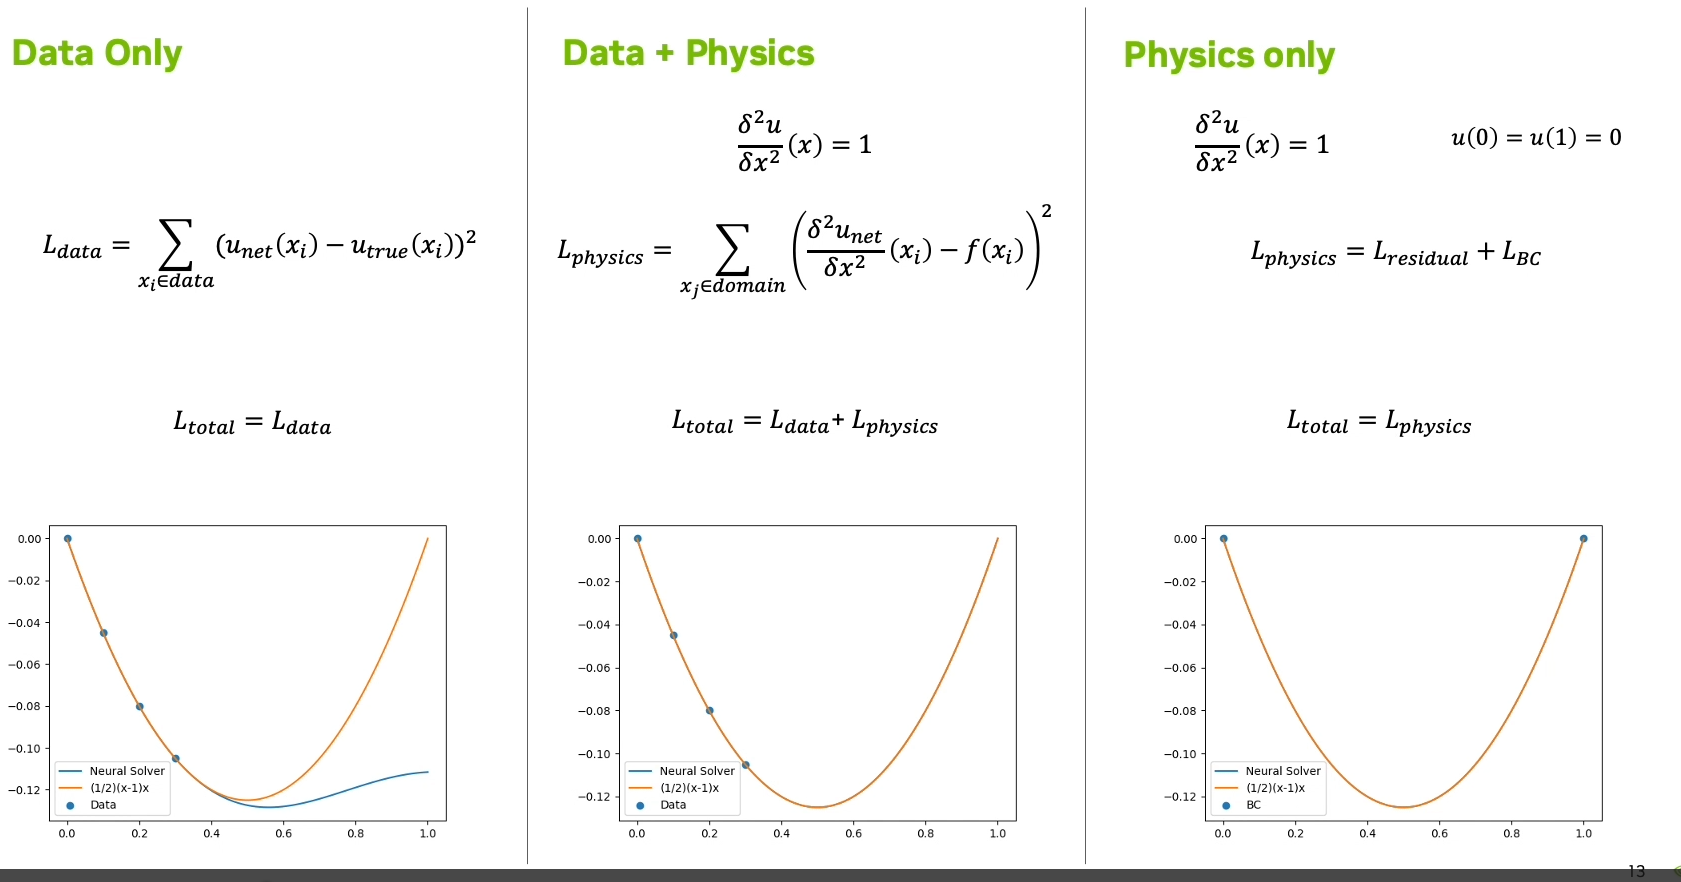



Vou resolver este problema utilizando não só otimizadores e uma PDE como loss function, mas vou replicar todo o workflow recomendado pela NVidia, escalável para qualquer projeto.

## 1 - Parâmetros utilizando o módulo Hydra

In [ ]:
import modulus
from modulus.hydra import to_yaml
from modulus.hydra.utils import compose
from modulus.hydra.config import ModulusConfig

cfg = compose(config_path="../../source_code/introductory/conf", config_name="config")
cfg.network_dir = 'outputs'    # Set the network directory for checkpoints
print(to_yaml(cfg))

In [ ]:
from sympy import Symbol
from modulus.geometry.primitives_1d import Line1D

# make geometry
x = Symbol("x")
geo = Line1D(0, 1)
y = 0.5 * (x - 1) * x

In [ ]:
samples = geo.sample_boundary(5)
print("Boundary Samples", samples)

samples = geo.sample_interior(5)
print("Interior Samples", samples)

In [ ]:
from sympy import Symbol, Number, Function
from modulus.eq.pde import PDE

class CustomPDE(PDE):
    def __init__(self, f=1.0):
        # coordinates
        x = Symbol("x")

        # make input variables
        input_variables = {"x": x}

        # make u function
        u = Function("u")(*input_variables)

        # source term
        if type(f) is str:
            f = Function(f)(*input_variables)
        elif type(f) in [float, int]:
            f = Number(f)

        # set equations
        self.equations = {}
        self.equations["custom_pde"] = (
            u.diff(x, 2) - f
        )  # "custom_pde" key name will be used in constraints

In [ ]:
from modulus.models.fully_connected import FullyConnectedArch
from modulus.key import Key

# make list of nodes to unroll graph on
eq = CustomPDE(f=1.0)
u_net = FullyConnectedArch(
    input_keys=[Key("x")], output_keys=[Key("u")], nr_layers=3, layer_size=32
)

nodes = eq.make_nodes() + [u_net.make_node(name="u_network")]

In [ ]:
# visualize the network and symbolic equation in Modulus:
print(u_net)
print(eq.pprint())

# graphically visualize the PyTorch execution graph
!pip install torchviz
import torch
from torchviz import make_dot
from IPython.display import Image

# pass dummy data through the model
data_out = u_net({"x": (torch.rand(10, 1)),})
make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
display(Image(filename='./u_network.png'))

In [ ]:
from modulus.models.meta import ModelMetaData
from dataclasses import dataclass
from modulus.models.module import Module
@dataclass
class MetaData(ModelMetaData):
    name: str = "UNet"
    # Optimization
    jit: bool = True
    cuda_graphs: bool = True
    amp_cpu: bool = True
    amp_gpu: bool = True
class UNet(Module)
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__(meta=MetaData())
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)




In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self):
        self.x = torch.arange(0, 1, 0.01)
        self.y = 0.5 * (self.x - 1) * self.x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = MyDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x.unsqueeze(1))

model = SimpleModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train loop
for epoch in range(10):  # Example: Train for 10 epochs
    for x, y in dataloader:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")



IndentationError: expected an indented block after class definition on line 5 (<ipython-input-21-b905664ac8bb>, line 6)